### Riddler Express

Start with 5 highlighted squares on an `infinite` board!

To go from one generation to the next, you consider every square’s eight neighbors (up, down, left, right and the four diagonal directions). If at least three of those squares are shaded, in the previous iteration, that square will be shaded in the next generation.

How many squares will be shaded in generation 10?



In [1]:
import numpy as np
import time 

# build initial state (gen 1)
matrix = np.zeros((9,9)) # start with 0s
overwrite = [(4,3), (4,4), (4,5), (3,4), (5,4)]
for idx in overwrite:
    matrix[idx] = 1

print(matrix)

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [2]:
def searchNeighbors(idx, m) -> int:
    """Pass in index and check if >= 3 neighbors are 1"""
    i,j = idx
    elements = [m[i, j-1], m[i-1, j], m[i+1, j], m[i, j+1],
                m[i-1, j-1], m[i-1, j+1], m[i+1, j-1], m[i+1, j+1]
               ]
    
    # check if v > any surrounding vals
    g = len([e for e in elements if e])
    
    if g >= 3:
        return 1
    return 0

assert(searchNeighbors((4,4), matrix) == 1) #center has 4, so should return a 1
assert(searchNeighbors((3,3), matrix) == 1) #(3,3) was 0, but switches to 1
assert(searchNeighbors((0,0), matrix) == 0) #(0,0) was 0, and stays 0

In [3]:
def fullSearch(m):
    """Pass in matrix, pad with 0s for easier index, and search over all"""
    m_pad = np.pad(m, pad_width=1, mode = 'constant', constant_values = 0)
    row = m.shape[0]
    col = m.shape[1]
    update = []
    for i in range(1,row+1):
        for j in range(1,col+1):
            if searchNeighbors((i,j), m_pad):
                update.append((i,j))
    for idx in update:
        m_pad[idx] = 1
    
    return m_pad

assert(np.sum(fullSearch(matrix)) == 9)

In [4]:
n = 10
s = time.time()
for i in range(1,n+1):
    print(f"Total shaded in generation {i}: {np.sum(matrix)}")
    matrix = fullSearch(matrix)
print(f"Total time: {time.time() - s:.5f}")

Total shaded in generation 1: 5.0
Total shaded in generation 2: 9.0
Total shaded in generation 3: 13.0
Total shaded in generation 4: 21.0
Total shaded in generation 5: 29.0
Total shaded in generation 6: 37.0
Total shaded in generation 7: 49.0
Total shaded in generation 8: 61.0
Total shaded in generation 9: 73.0
Total shaded in generation 10: 89.0
Total time: 0.00444


### Extra Credit:

Extra credit: As N gets very, very large, approximately how many squares will be shaded in generation N (in terms of N)?

Current approach scales very poorly, as shown below: 

In [5]:
# This does not scale - see below:
# build initial state (gen 1)
matrix = np.zeros((9,9)) # start with 0s
overwrite = [(4,3), (4,4), (4,5), (3,4), (5,4)]
for idx in overwrite:
    matrix[idx] = 1
    
n = 200
s = time.time()
for i in range(1,n+1):
    #print(f"Total shaded in generation {i}: {np.sum(matrix)}")
    matrix = fullSearch(matrix)
    if i % 50 == 0:
        print(f"Total time for gen {i}: {time.time() - s:.5f}")

Total time for gen 50: 0.22064
Total time for gen 100: 1.51831
Total time for gen 150: 4.86441
Total time for gen 200: 11.40988


#### Rewrite:

The main operation is looking at all neighbors and summing up 1s, which can happen in a vectorized manner! Avoiding a for loop is going to massively speed up the process. 

##### Timing Comparison

note: These came from earlier testing

- loop: 
    - 100 runs took 1.5 seconds
    - 200 runs took 11.4 seconds

- vectorized:
    - 100 runs took 0.05 seconds --> 30X speedup!
    - 200 runs took .1522 seconds --> 76X speedup!
    
    
Vectorized will massively outperform, especially as our matrix grows in size!

In [6]:
def vectorizedSearch(m):
    """
    Rewrite search for surrounding 8 neighbors using matrix addition (vectorized approach)
    
    Process:
    - pad matrix so border can be compared (allows for ever-increasing search space)
    - solve for all 8 neighbors using matrix addition
    - any element >= 3 is 1, else 0
    """
    arr = np.pad(m, pad_width=1, mode = 'constant', constant_values = 0)
    r,c = arr.shape
    empty_arr = np.zeros((r,c)) # store results

    # rows
    empty_arr[1:] += arr[:r-1] # same as summing row above (i - 1, j)
    empty_arr[:r-1] += arr[1:r] # same as summing row below (i + 1, j)

    # cols
    empty_arr[:, 1:] += arr[:, :c-1] # same as summing left col (i, j - 1)
    empty_arr[:, :c-1] += arr[:, 1:c] # same as summing right col (i, j + 1)

    # diag down-right
    empty_arr[:r-1, :c-1] += arr[1:r, 1:c] 

    # diag up-right
    empty_arr[1:, :c-1] += arr[:r-1, 1:c] 

    # diag down-left
    empty_arr[:r-1, 1:] += arr[1:r, :c-1] 

    # diag down-right
    empty_arr[1:, 1:] += arr[:r-1, :c-1] 

    # rewrite as 1 where >= 3, else 0 -> overwrite
    arr = np.where(empty_arr >= 3 , 1, 0)
    
    return arr

# testing:
arr = np.zeros((9,9)) # start with 0s
overwrite = [(4,3), (4,4), (4,5), (3,4), (5,4)]
for idx in overwrite:
    arr[idx] = 1
    
# gen 2: 
arr = vectorizedSearch(arr)
assert(np.sum(arr) == 9)

# gen 3: 
arr = vectorizedSearch(arr)
assert(np.sum(arr) == 13)

# gen 4: 
arr = vectorizedSearch(arr)
assert(np.sum(arr) == 21)

In [7]:
### rerun first 10
import time
arr = np.zeros((9,9)) # start with 0s
overwrite = [(4,3), (4,4), (4,5), (3,4), (5,4)]
for idx in overwrite:
    arr[idx] = 1

### gen
gen = 2_500
start = time.time()

### store output:
sum_n = []

for i in range(1,gen+1):
    if i % 500 == 0:
        print(f"Total shaded in generation {i}: {np.sum(arr)}")
        print(f"Total time: {time.time() - start:.4}")
    
    # add sum relative to n
    sum_n.append(np.sum(arr))
        
    # neighborhood search
    arr = vectorizedSearch(arr)


Total shaded in generation 500: 167669
Total time: 1.574
Total shaded in generation 1000: 668669
Total time: 14.99
Total shaded in generation 1500: 1503001
Total time: 49.82
Total shaded in generation 2000: 2670669
Total time: 118.9
Total shaded in generation 2500: 4171669
Total time: 226.1


In [8]:
for i in [10,100,200, 500,1000,1500, 2000, 2500]:
    print(sum_n[i-1] / (i**2))

0.89
0.6869
0.676725
0.670676
0.668669
0.6680004444444444
0.66766725
0.66746704


Text(0.5, 0, '# of Generations')

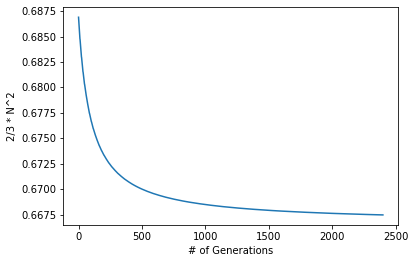

In [9]:
from matplotlib import pyplot as plt
solved = [sum_n[i-1] / (i**2) for i in range(100,len(sum_n) + 1)]
plt.plot(solved)
plt.ylabel("2/3 * N^2")
plt.xlabel("# of Generations")

### Final Solution for Extra Credit: 

Convergence seems to be occurring at: 

$\frac{2}{3} * N^{2}$

where N = # of generations